In [112]:
import numpy as np
from sklearn.ensemble import RandomForestRegressorp
from sklearn.neighbors import kneighbors_graph, NearestNeighbors
import scipy
import scipy.sparse as sparse
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, confusion_matrix, 
                             classification_report, roc_curve, auc)

In [3]:
plt.style.use('seaborn-deep')

1. Q is the dividend
2. m is the amount of time we can exercise the option (discretization)
3. N is the number of simulations

In [7]:
# Statics 
T = 1./12
m = 2
K = 264.
r = 0.01
S0 = 263.24
sigma = 0.2
N = 10000
Q = 0

In [14]:
dt=T/m 
sqrt_dt=np.sqrt(dt)
S=np.zeros((m+1,N))
dW=np.zeros((m+1,N))
S[0]=S0

## Construct the Stock price, GBM
for n in range(1,m+1):
    W=np.random.standard_normal(size=N)
    S[n]=S[n-1]*np.exp((r-sigma**2/2.0)*dt+sigma*sqrt_dt*W)
    dW[n]=sqrt_dt*W

In [33]:
## The payoff at the terminal time
Y=np.maximum(S[-1]-K,0)
X=S[1]
X=X.reshape((X.size,1))

In [34]:
 #the batch size is N

Text(0.5, 1.0, 'Final payoff wrt the stock price at mid-time exercise node')

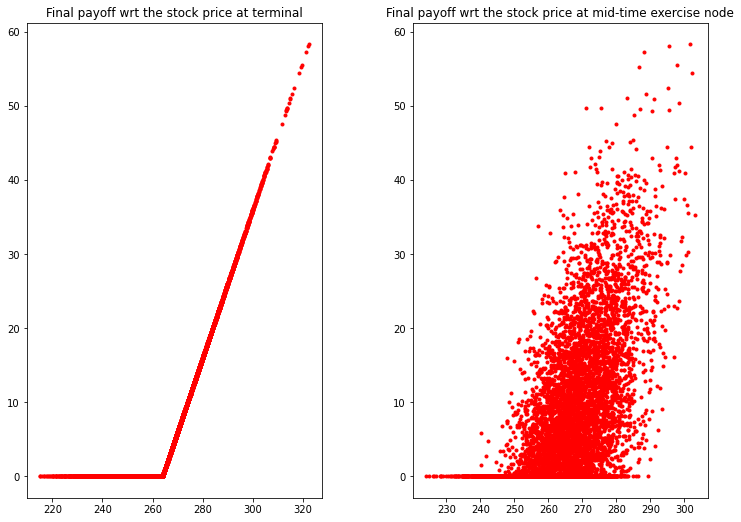

In [40]:
f, (ax1, ax2) =plt.subplots(1, 2, figsize=(10,7))
plt.tight_layout(pad=0.4, w_pad=6, h_pad=1.0)
ax1.plot(S[2], Y , 'r.')
ax2.plot(S[1], Y , 'r.')

ax1.set_title('Final payoff wrt the stock price at terminal')
ax2.set_title('Final payoff wrt the stock price at mid-time exercise node')

# Plotting the final payoff w.r.t the price at the first exercise time node

## Regression methods

### Polynomial curve fitting
The polyfit function uses the least square projection method. Results are deterministic. 

In [42]:
reg1 = np.polyfit(S[1], Y, 5) ## Fit the payoff with data 

In [43]:
expected_Y_polynomial = np.polyval(reg1, S[1])

### Gaussian Kernel regression

We use the $N\times0.01$ nearest neighborhood points.

1. metric 'minkowski'
2. p=2 the power

Need to check t he K-nearest nbhd documents. 
https://scikit-learn.org/stable/modules/neighbors.html#unsupervised-neighbors

In [54]:
# Gaussian kernel regression using only nearest neighbors (for performance matters)
NN = kneighbors_graph(X.reshape((N,1)), int(N * 0.01), mode='distance').nonzero()
l = 2

x = NN[0]
y = NN[1]

In [60]:
W = scipy.sparse.lil_matrix((N, N))
W[x, y] = np.exp(- (X[y] - X[x]) ** 2 / (2 * l ** 2))[0]

In [62]:
# As (i, i) not in NN, we add it manually
W.setdiag(np.ones(N))

# Sum over each row and update the weight
sum_weights = W.sum(axis=0)
W = W.dot(scipy.sparse.diags(np.array(1 / sum_weights)[0]))

# E[Y_(t+dt)_j|F_t] = f(X_j) = sum(w(i, j)*Y(i))
expected_Y_kernel = W.dot(Y)

Text(0.5, 1.0, 'Gaussian Kernel Regression')

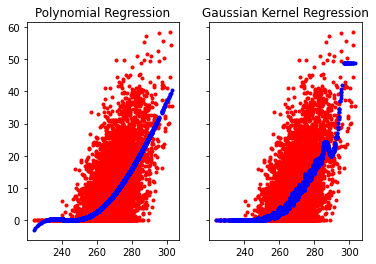

In [67]:
f2, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

ax1.plot(S[1], Y , 'r.')
ax1.plot(S[1], expected_Y_polynomial , 'b.')

ax1.set_title('Polynomial Regression')
ax2.plot(S[1], Y , 'r.')
ax2.plot(S[1], expected_Y_kernel , 'b.')

ax2.set_title('Gaussian Kernel Regression')


## Random forest

1. n_estimators is the number trees used
2. max_depth.The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.
3. min_samples_split. The minimum number of samples required to split an internal node.
4. min_samples_leaf: The minimum number of samples required to be at a leaf node.
5. n_jobs: n_jobs=-1 means using all the processors. 
6. max_features: The number of features to consider when looking for the best split. Or [max_features] is the size of the random subsets of features to consider when splitting a node.

In [72]:
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1)

In [74]:
reg1 = rf.fit(X, Y)
expected_Y_rf = rf.predict(X)

In [119]:
np.mean((Y-expected_Y_rf)**2)

9.58860326223909

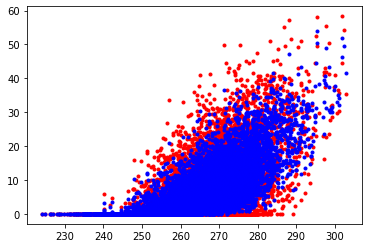

In [76]:
plt.plot(X, Y , 'r.')
plt.plot(X, expected_Y_rf, 'b.')

In [132]:
print(rf.max_features)

1.0


#### There could be overfitting issues.

In [160]:
params = {'n_estimators': [40, 100,200],
          'max_features': [1, 5, 30]}

In [161]:
forest = RandomForestRegressor() ## We are using regressor in this case
grid_forest=GridSearchCV(forest,params,cv=3,n_jobs=-1)
### cv=3: using 3 fold validation

In [162]:
grid_forest.fit(X, Y)

GridSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_features': [1, 5, 30],
                         'n_estimators': [40, 100, 200]})

In [163]:
grid_forest.best_params_

{'max_features': 30, 'n_estimators': 200}

In [164]:
Y_pred=grid_forest.predict(X)

In [165]:
np.mean((Y-Y_pred)**2)

9.486927844191303

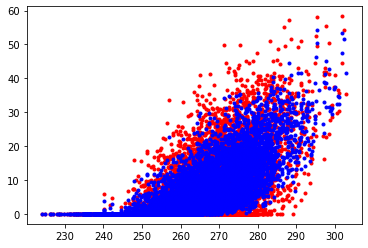

In [166]:
plt.plot(X, Y , 'r.')
plt.plot(X, Y_pred, 'b.')

### Testing the model learned

In [167]:
S_test=np.zeros((m+1,N))
dW_test=np.zeros((m+1,N))
S_test[0]=S0

## Construct the Stock price, GBM
for n in range(1,m+1):
    W_test=np.random.standard_normal(size=N)
    S_test[n]=S_test[n-1]*np.exp((r-sigma**2/2.0)*dt+sigma*sqrt_dt*W_test)
    dW_test[n]=sqrt_dt*W_test

In [168]:
Y_test=np.maximum(S_test[-1]-K,0)
X_test=S_test[1]
X_test=X_test.reshape((X_test.size,1))

In [169]:
Y_test_predict=grid_forest.predict(X_test)

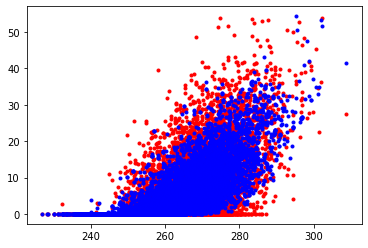

In [170]:
plt.plot(X_test, Y_test , 'r.')
plt.plot(X_test, Y_test_predict, 'b.')